This notebook presents data exploration after pre-processing

In [ ]:
import pandas as pd
import re
import gensim
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#setting parameters for data visualization
np.set_printoptions(threshold=None, precision=2)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.precision', 2) # Changed 'precision' to 'display.precision'

In [ ]:
#expand jupyter cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:

messages = pd.read_csv('/content/drive/MyDrive/movie-corpus/movie_lines_pre_processed_for_test.tsv', sep='\t', header=None)


In [ ]:
messages.columns = ['msg_line', 'user_id', 'movie_id', 'msg', 'msg_pre_processed', 'msg_2', 'target']

In [ ]:
messages.head(10)

,msg_line,user_id,movie_id,msg,msg_pre_processed,msg_2,target
0,L49,u0,m0,Did you change your hair?,No.,change hair,1
1,L59,u9,m0,I missed you.,It says here you exposed yourself to a group o...,miss,0
2,L60,u8,m0,It says here you exposed yourself to a group o...,It was a bratwurst. I was eating lunch.,say expose group freshman girl,0
3,L61,u9,m0,It was a bratwurst. I was eating lunch.,With the teeth of your zipper?,bratwurst eat lunch,0
4,L63,u7,m0,You the new guy?,So they tell me...,new guy,1
5,L64,u2,m0,So they tell me...,C'mon. I'm supposed to give you the tour.,tell,0
6,L66,u7,m0,So -- which Dakota you from?,North actually. How'd you ?,dakota,1
7,L67,u2,m0,North actually. How'd you ?,I was kidding. People actually live there?,north actually howd,1
8,L68,u7,m0,I was kidding. People actually live there?,Yeah. A couple. We're outnumbered by the cows ...,kid people actually live,1
9,L69,u2,m0,Yeah. A couple. We're outnumbered by the cows ...,How many people were in your old school?,yeah couple outnumber cow though,0


In [ ]:
# Data exploration
# The number of answer is bigger than questions, but the neural network will be trained using the 'stratify' parameter to keep the proportionality of data in train dataset


messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   msg_line           30000 non-null  object
 1   user_id            30000 non-null  object
 2   movie_id           30000 non-null  object
 3   msg                30000 non-null  object
 4   msg_pre_processed  30000 non-null  object
 5   msg_2              30000 non-null  object
 6   target             30000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 1.6+ MB


In [ ]:
messages.describe()

,target
count,30000.00
mean,0.33
std,0.47
min,0.00
25%,0.00
50%,0.00
75%,1.00
max,1.00


In [ ]:

data = messages['msg_pre_processed']

<Axes: >

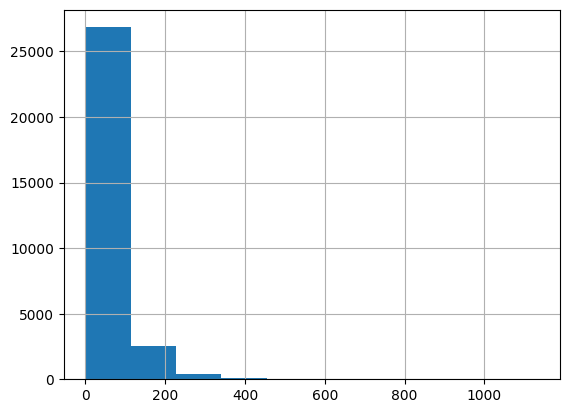

In [ ]:
#histogram to display the number of character of each message
data.str.len().hist()

In [ ]:
# Value Types

#checking the average word length
data_set = [type(item) for item in data]
data_set = set(data_set)
data_set

{str}

In [ ]:
# Print float values

float_val = [it for it in data if isinstance(it, float)]
print(len(float_val))
float_val = set(float_val)
print(float_val)

0
set()


In [ ]:
messages[messages['msg_pre_processed'].isna()]

,msg_line,user_id,movie_id,msg,msg_pre_processed,msg_2,target


In [ ]:
# Removing non-alphabetical messages (not used)

<Axes: >

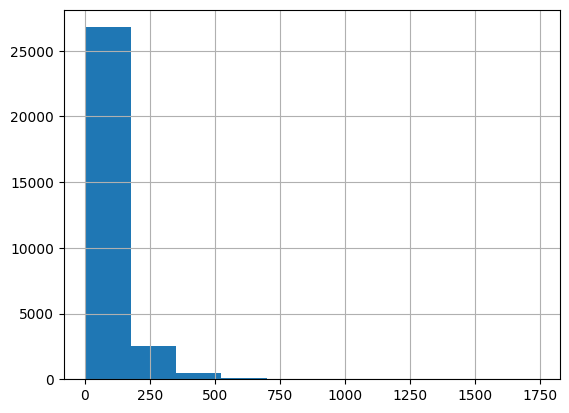

In [ ]:
#number of words for each message
data.str.split(' ').\
    map(lambda x: len(str(x))).\
    hist()

<Axes: >

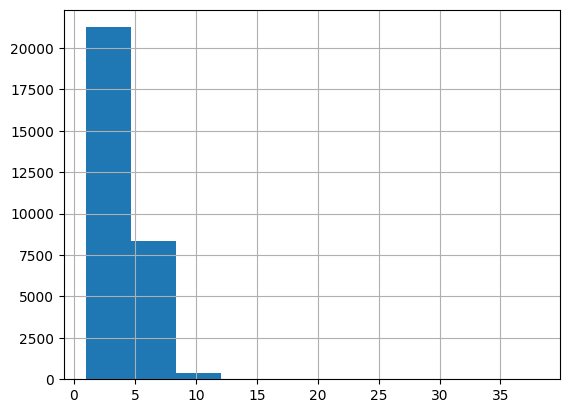

In [ ]:
#checking the average word length
data.str.split(' ').\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

In [ ]:
# Distribuition of stopwords in the mesages

In [ ]:
import nltk
from nltk.corpus import stopwords

# Download the 'stopwords' dataset if it hasn't been downloaded yet
nltk.download('stopwords')

#checkig the distribuition of stopwrds in the mesages
stop=set(stopwords.words('english'))
corpus=[]
msg_ = data.str.split()
msg_ = msg_.values.tolist()
corpus=[word for i in msg_ for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
len(list(dic.values()))

156

In [ ]:
import matplotlib.pyplot as plt

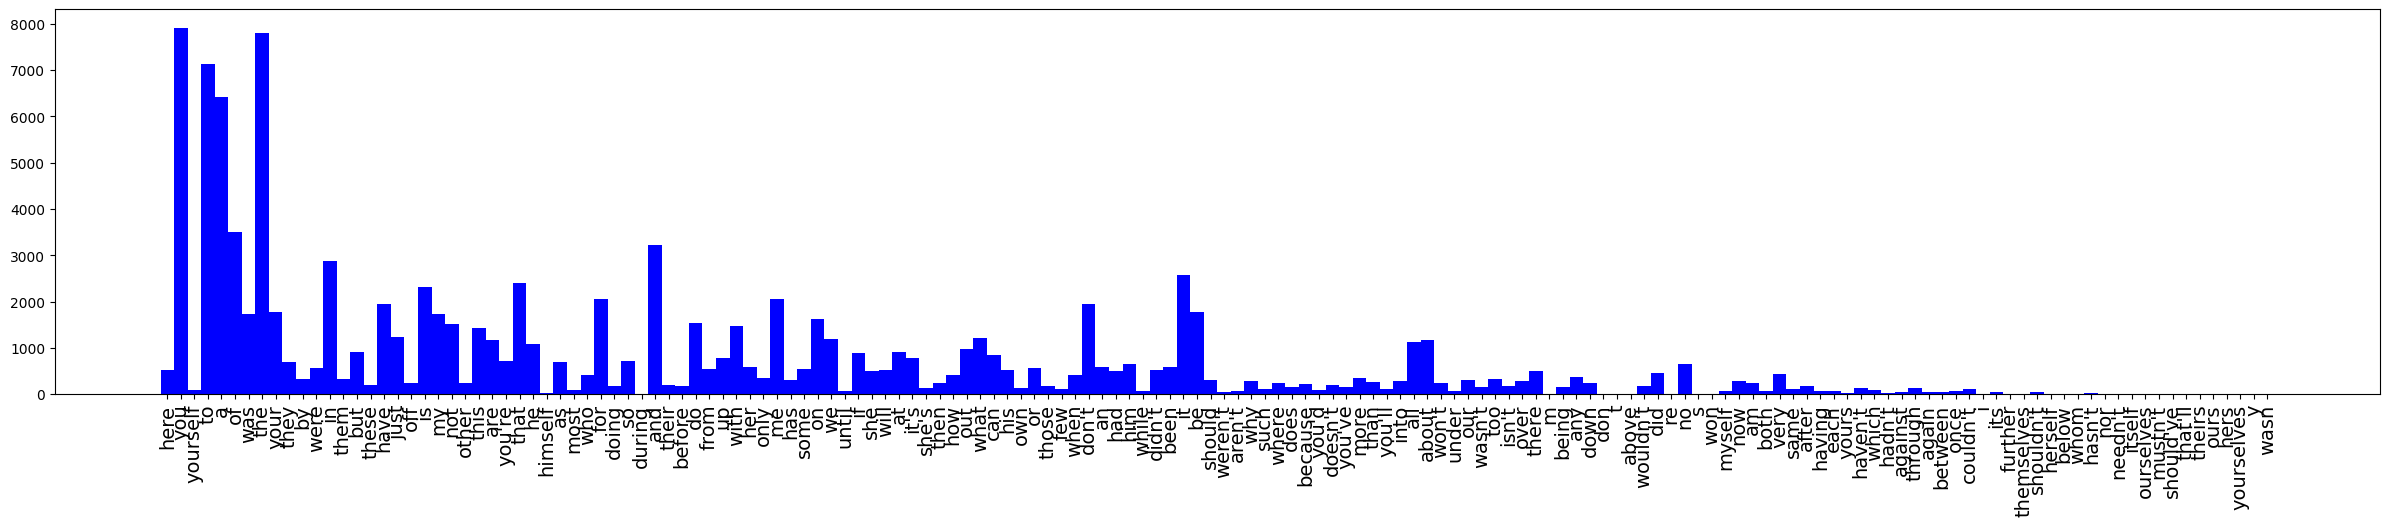

In [ ]:
x = dic.keys()
y = dic.values()
plt.subplots(figsize=(30,5))
plt.bar(x, y, 1, color='b')
plt.xticks(list(x), rotation=90, fontsize=14)
plt.show()

In [ ]:
# Occurence of words

In [ ]:
from collections import Counter
import seaborn as sns

<Axes: >

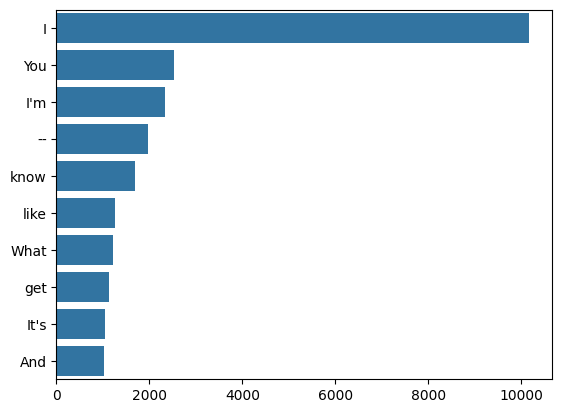

In [ ]:
#ploting the occurences of each word
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

In [ ]:

from nltk.util import ngrams

In [ ]:
#get the most frequent n-grams
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

In [ ]:
def plot_n_gram(corpus, n=2):
    top_n_bigrams=get_top_ngram(corpus,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

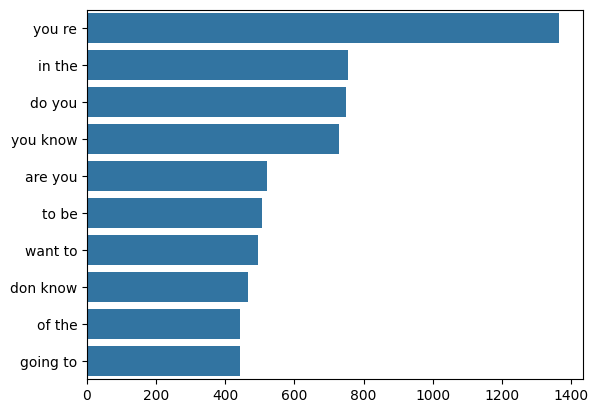

In [ ]:
plot_n_gram(data, 2)

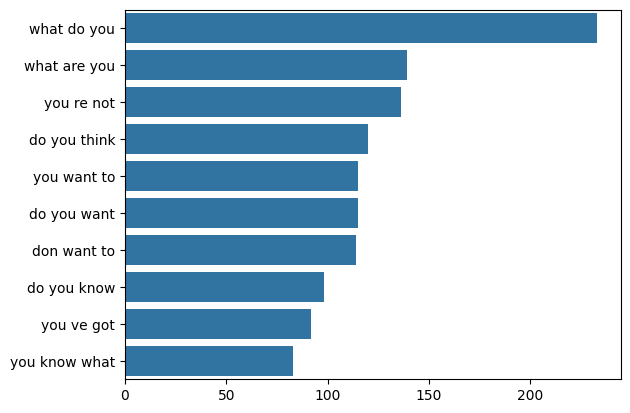

In [ ]:
plot_n_gram(data, 3)

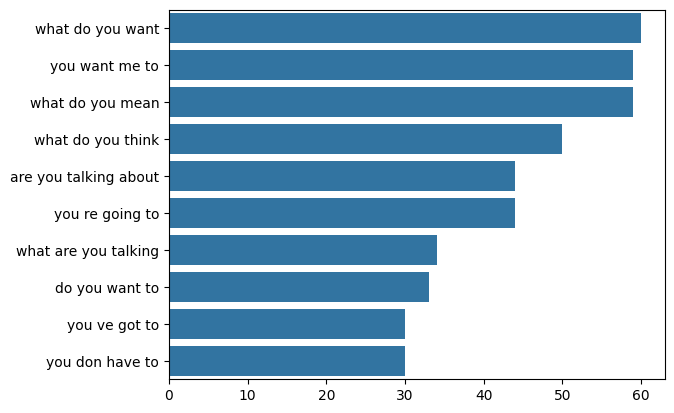

In [ ]:
plot_n_gram(data, 4)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


                                   msg_pre_processed  \
0                                                No.   
1  It says here you exposed yourself to a group o...   
2            It was a bratwurst. I was eating lunch.   
3                     With the teeth of your zipper?   
4                                 So they tell me...   
5          C'mon. I'm supposed to give you the tour.   
6                        North actually. How'd you ?   
7         I was kidding. People actually live there?   
8  Yeah. A couple. We're outnumbered by the cows ...   
9           How many people were in your old school?   

                                           sentiment  
0  {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...  
1  {'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...  
2  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
3  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
4  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
5  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound... 

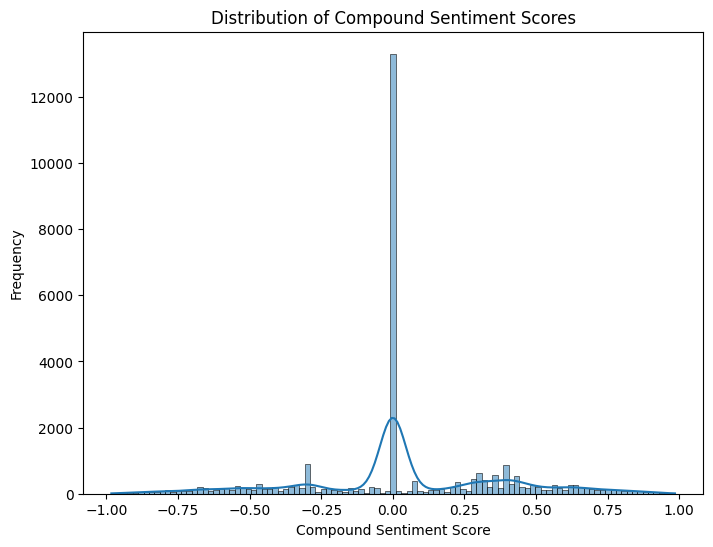

sentiment_category
Neutral     13534
Positive     9725
Negative     6741
Name: count, dtype: int64


In [ ]:
# prompt: Sentimental analysis

# Assuming you want to perform sentiment analysis on the 'msg_pre_processed' column
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download the VADER lexicon if you haven't already
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment scores for a message
def get_sentiment(message):
    scores = analyzer.polarity_scores(message)
    return scores

# Apply the sentiment analysis function to each message
messages['sentiment'] = messages['msg_pre_processed'].astype(str).apply(get_sentiment)

# Example: Accessing the sentiment scores
print(messages[['msg_pre_processed', 'sentiment']].head(10))

# Further analysis (e.g., average sentiment, sentiment distribution)
messages['compound_sentiment'] = messages['sentiment'].apply(lambda x: x['compound'])

# Analyze sentiment distribution
plt.figure(figsize=(8, 6))
sns.histplot(messages['compound_sentiment'], kde=True)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Example: Categorize messages based on sentiment
def categorize_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

messages['sentiment_category'] = messages['compound_sentiment'].apply(categorize_sentiment)

print(messages['sentiment_category'].value_counts())

In [ ]:

import spacy

nlp = spacy.load("en_core_web_sm")

In [ ]:
#transform the messages in a big document
def get_entities(corpus, int_limit=0, end_limit=100):
    msg_all = ' '.join(data[int_limit:end_limit])
    doc = nlp(msg_all)

    return [(x.text,x.label_) for x in doc.ents]

In [ ]:
%%time

ent_list = set()
skip = 1000
i = 0
lim = len(data)
#lim = 20000

while(i < lim):
    ent_list = set(get_entities(data, i, i+skip))
    ent_list.union(ent_list)
    i = i + skip
    print('Processed '+str(i)+' of '+str(lim)+' messages')

Processed 1000 of 30000 messages
Processed 2000 of 30000 messages
Processed 3000 of 30000 messages
Processed 4000 of 30000 messages
Processed 5000 of 30000 messages
Processed 6000 of 30000 messages
Processed 7000 of 30000 messages
Processed 8000 of 30000 messages
Processed 9000 of 30000 messages
Processed 10000 of 30000 messages
Processed 11000 of 30000 messages
Processed 12000 of 30000 messages
Processed 13000 of 30000 messages
Processed 14000 of 30000 messages
Processed 15000 of 30000 messages
Processed 16000 of 30000 messages
Processed 17000 of 30000 messages
Processed 18000 of 30000 messages
Processed 19000 of 30000 messages
Processed 20000 of 30000 messages
Processed 21000 of 30000 messages
Processed 22000 of 30000 messages
Processed 23000 of 30000 messages
Processed 24000 of 30000 messages
Processed 25000 of 30000 messages
Processed 26000 of 30000 messages
Processed 27000 of 30000 messages
Processed 28000 of 30000 messages
Processed 29000 of 30000 messages
Processed 30000 of 3000

In [ ]:
len(ent_list)

222

In [ ]:
ent_list

{('"Baloney', 'WORK_OF_ART'),
 ("' minute", 'TIME'),
 ("' night", 'TIME'),
 ("'s County", 'GPE'),
 ('100 percent', 'PERCENT'),
 ('1960', 'DATE'),
 ('40-60', 'CARDINAL'),
 ('472 1862', 'DATE'),
 ('51-49', 'DATE'),
 ('60-40', 'CARDINAL'),
 ('62700000', 'MONEY'),
 ('702', 'CARDINAL'),
 ('A million dollars', 'MONEY'),
 ('A week', 'DATE'),
 ('A week ago', 'DATE'),
 ('Ace', 'PERSON'),
 ('Al Capone', 'PERSON'),
 ('Amy', 'PERSON'),
 ('Andy', 'PERSON'),
 ('Andy Stone', 'PERSON'),
 ('Angelo', 'PERSON'),
 ('Arkansas', 'GPE'),
 ('Artie', 'PERSON'),
 ('Australia', 'GPE'),
 ('Back - Back - Back', 'PERSON'),
 ("Bad fuckin'", 'PERSON'),
 ('Billy', 'PERSON'),
 ('Bob', 'PERSON'),
 ('Bullshit', 'PERSON'),
 ('Buster', 'PERSON'),
 ('Caesar', 'ORG'),
 ('Carmine', 'PERSON'),
 ('Carmine', 'PRODUCT'),
 ('Casino Executive', 'ORG'),
 ('Ch-Charlie M', 'PERSON'),
 ('Charlie', 'PERSON'),
 ('Charlie Clark', 'PERSON'),
 ('Charlie M', 'PERSON'),
 ('Chicken', 'PERSON'),
 ('Chinn', 'PERSON'),
 ('Christmas', 'DATE'),
 ('

In [ ]:
ent_df = pd.DataFrame(list(ent_list))

In [ ]:
ent_df

,0,1
0,thirty-five years,DATE
1,FedEx,GPE
2,Charlie M,PERSON
3,Los Angeles,GPE
4,Sam Rothstein,PERSON
5,A million dollars,MONEY
6,A week ago,DATE
7,Irish,NORP
8,ten thousand francs,MONEY
9,Russia,GPE


In [ ]:
# Entity frequency


def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]

In [ ]:
# Most comon tokens per entity

In [ ]:
# Parts of Speach Tagging

In [ ]:
nltk.download('averaged_perceptron_tagger')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
msg_no_space = [remove_duplicated_spaces(str(m)) for m in data]
msg_no_space = pd.Series(msg_no_space)

In [ ]:
!pip install nltk
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize

def remove_duplicated_spaces(corpus):
    #remove duplicated spaces
    import re # Importing re inside the function to avoid potential import errors
    return re.sub(r' +', ' ', corpus)

def pos(text):
    #matched = re.match(r" +", text)
    if text != ' ':
        #print(text)
        pos=nltk.pos_tag(word_tokenize(text))
        #print(pos)
        pos=list(map(list,zip(*pos)))[1]
        return pos
    return



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<Axes: >

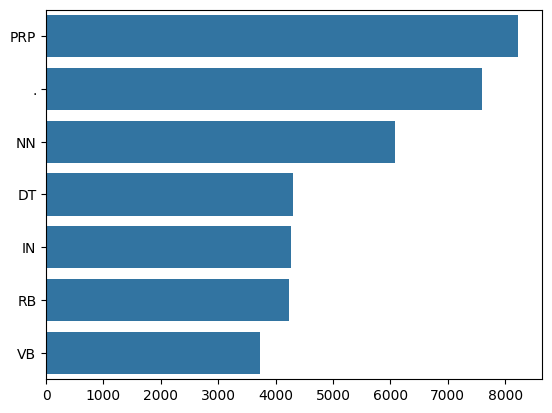

In [ ]:
x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

In [ ]:

### most commonly nouns
def get_adjs(text, _tag='NN'):
    pos=nltk.pos_tag(word_tokenize(text))
    for word,tag in pos:
        if tag == _tag:
            [].append(word)
    return []

In [ ]:
%%time
words=data.apply(lambda x : get_adjs(x))
words=[x for l in words for x in l]
counter=Counter(words)

CPU times: user 30.5 s, sys: 497 ms, total: 31 s
Wall time: 32 s


Text complexity

In [ ]:
!pip install textstat # Install the textstat module using pip

from textstat import flesch_reading_ease  # Import the flesch_reading_ease function

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 37.6 MB/s eta 0:00:00


CPU times: user 2.99 s, sys: 10.4 ms, total: 3 s
Wall time: 6.29 s


<Axes: >

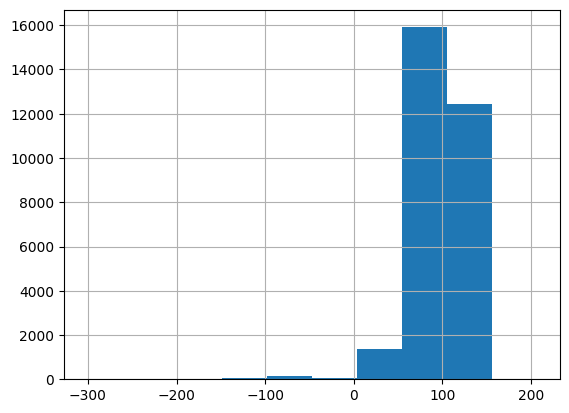

In [ ]:
%%time
reading = data.\
   apply(lambda x : flesch_reading_ease(x))
reading.hist()

In [ ]:
x=[i for i in range(len(reading)) if reading[i]<0]

messages.iloc[x]['msg_pre_processed'].head()

,msg_pre_processed
10,Thirty-two.
85,Neither has his heterosexuality.
121,Seven-thirty?
154,Hopefully.
295,Unwelcome.
